In [1]:
from zrna import *
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [19]:
import os

os.chdir("/Users/cardinal/Documents/GitHub/casp-rna/")

In [18]:
from target import calculate_target

targets = [
    "data/casp15_targets/r1107",
    "data/casp15_targets/r1108",
    "data/casp15_targets/r1116",
    "data/casp15_targets/r1117",
    "data/casp15_targets/r1126",
    "data/casp15_targets/r1128",
    "data/casp15_targets/r1136",
    "data/casp15_targets/r1138",
    "data/casp15_targets/r1149",
    "data/casp15_targets/r1156",
    "data/casp15_targets/r1189",
    "data/casp15_targets/r1190",
]

for target in targets:
    print(f"Running {target}")
    calculate_target(target, metric="all", preprocess=True, run_summary=True)

# Figure 3A - Zrna Heatmap

In [6]:
metrics_is_lower_better = {"clashscore": "min", "global_rmsd": "min", "gdt_ts": "max", "tm_score": "max", "lddt": "max",
           "inf_all": "max"}

zrna_weights = {"lddt":1/8,
        "inf_all":1/8,
        "tm_score":1/3,
        "gdt_ts":1/3,
        'clashscore':1/12} 

rna = pd.read_csv("scores/rna_metrics.csv")
best_score = best_score_across_all_confs(rna.copy(), metrics_is_lower_better)

# of models: 29
The TM-score mean is -20.17310344827586
The TM-score std is 37.627209533330536
# of models: 29
The TM-score mean is -8.831538461538461
The TM-score std is nan
# of models: 29
The TM-score mean is -17.15931034482759
The TM-score std is 10.838853779275448
# of models: 29
The TM-score mean is -15.677857142857146
The TM-score std is nan
# of models: 29
The TM-score mean is 33.17089655172414
The TM-score std is 12.71153438293776
# of models: 29
The TM-score mean is 33.17089655172414
The TM-score std is 12.71153438293776
# of models: 29
The TM-score mean is 0.3170379310344828
The TM-score std is 0.08506194665144441
# of models: 29
The TM-score mean is 0.3170379310344828
The TM-score std is 0.08506194665144441
# of models: 29
The TM-score mean is 0.4568750198961903
The TM-score std is 0.12843699355072777
# of models: 29
The TM-score mean is 0.4568750198961903
The TM-score std is 0.12843699355072777
# of models: 29
The TM-score mean is 0.6699999999999998
The TM-score std is 0.1

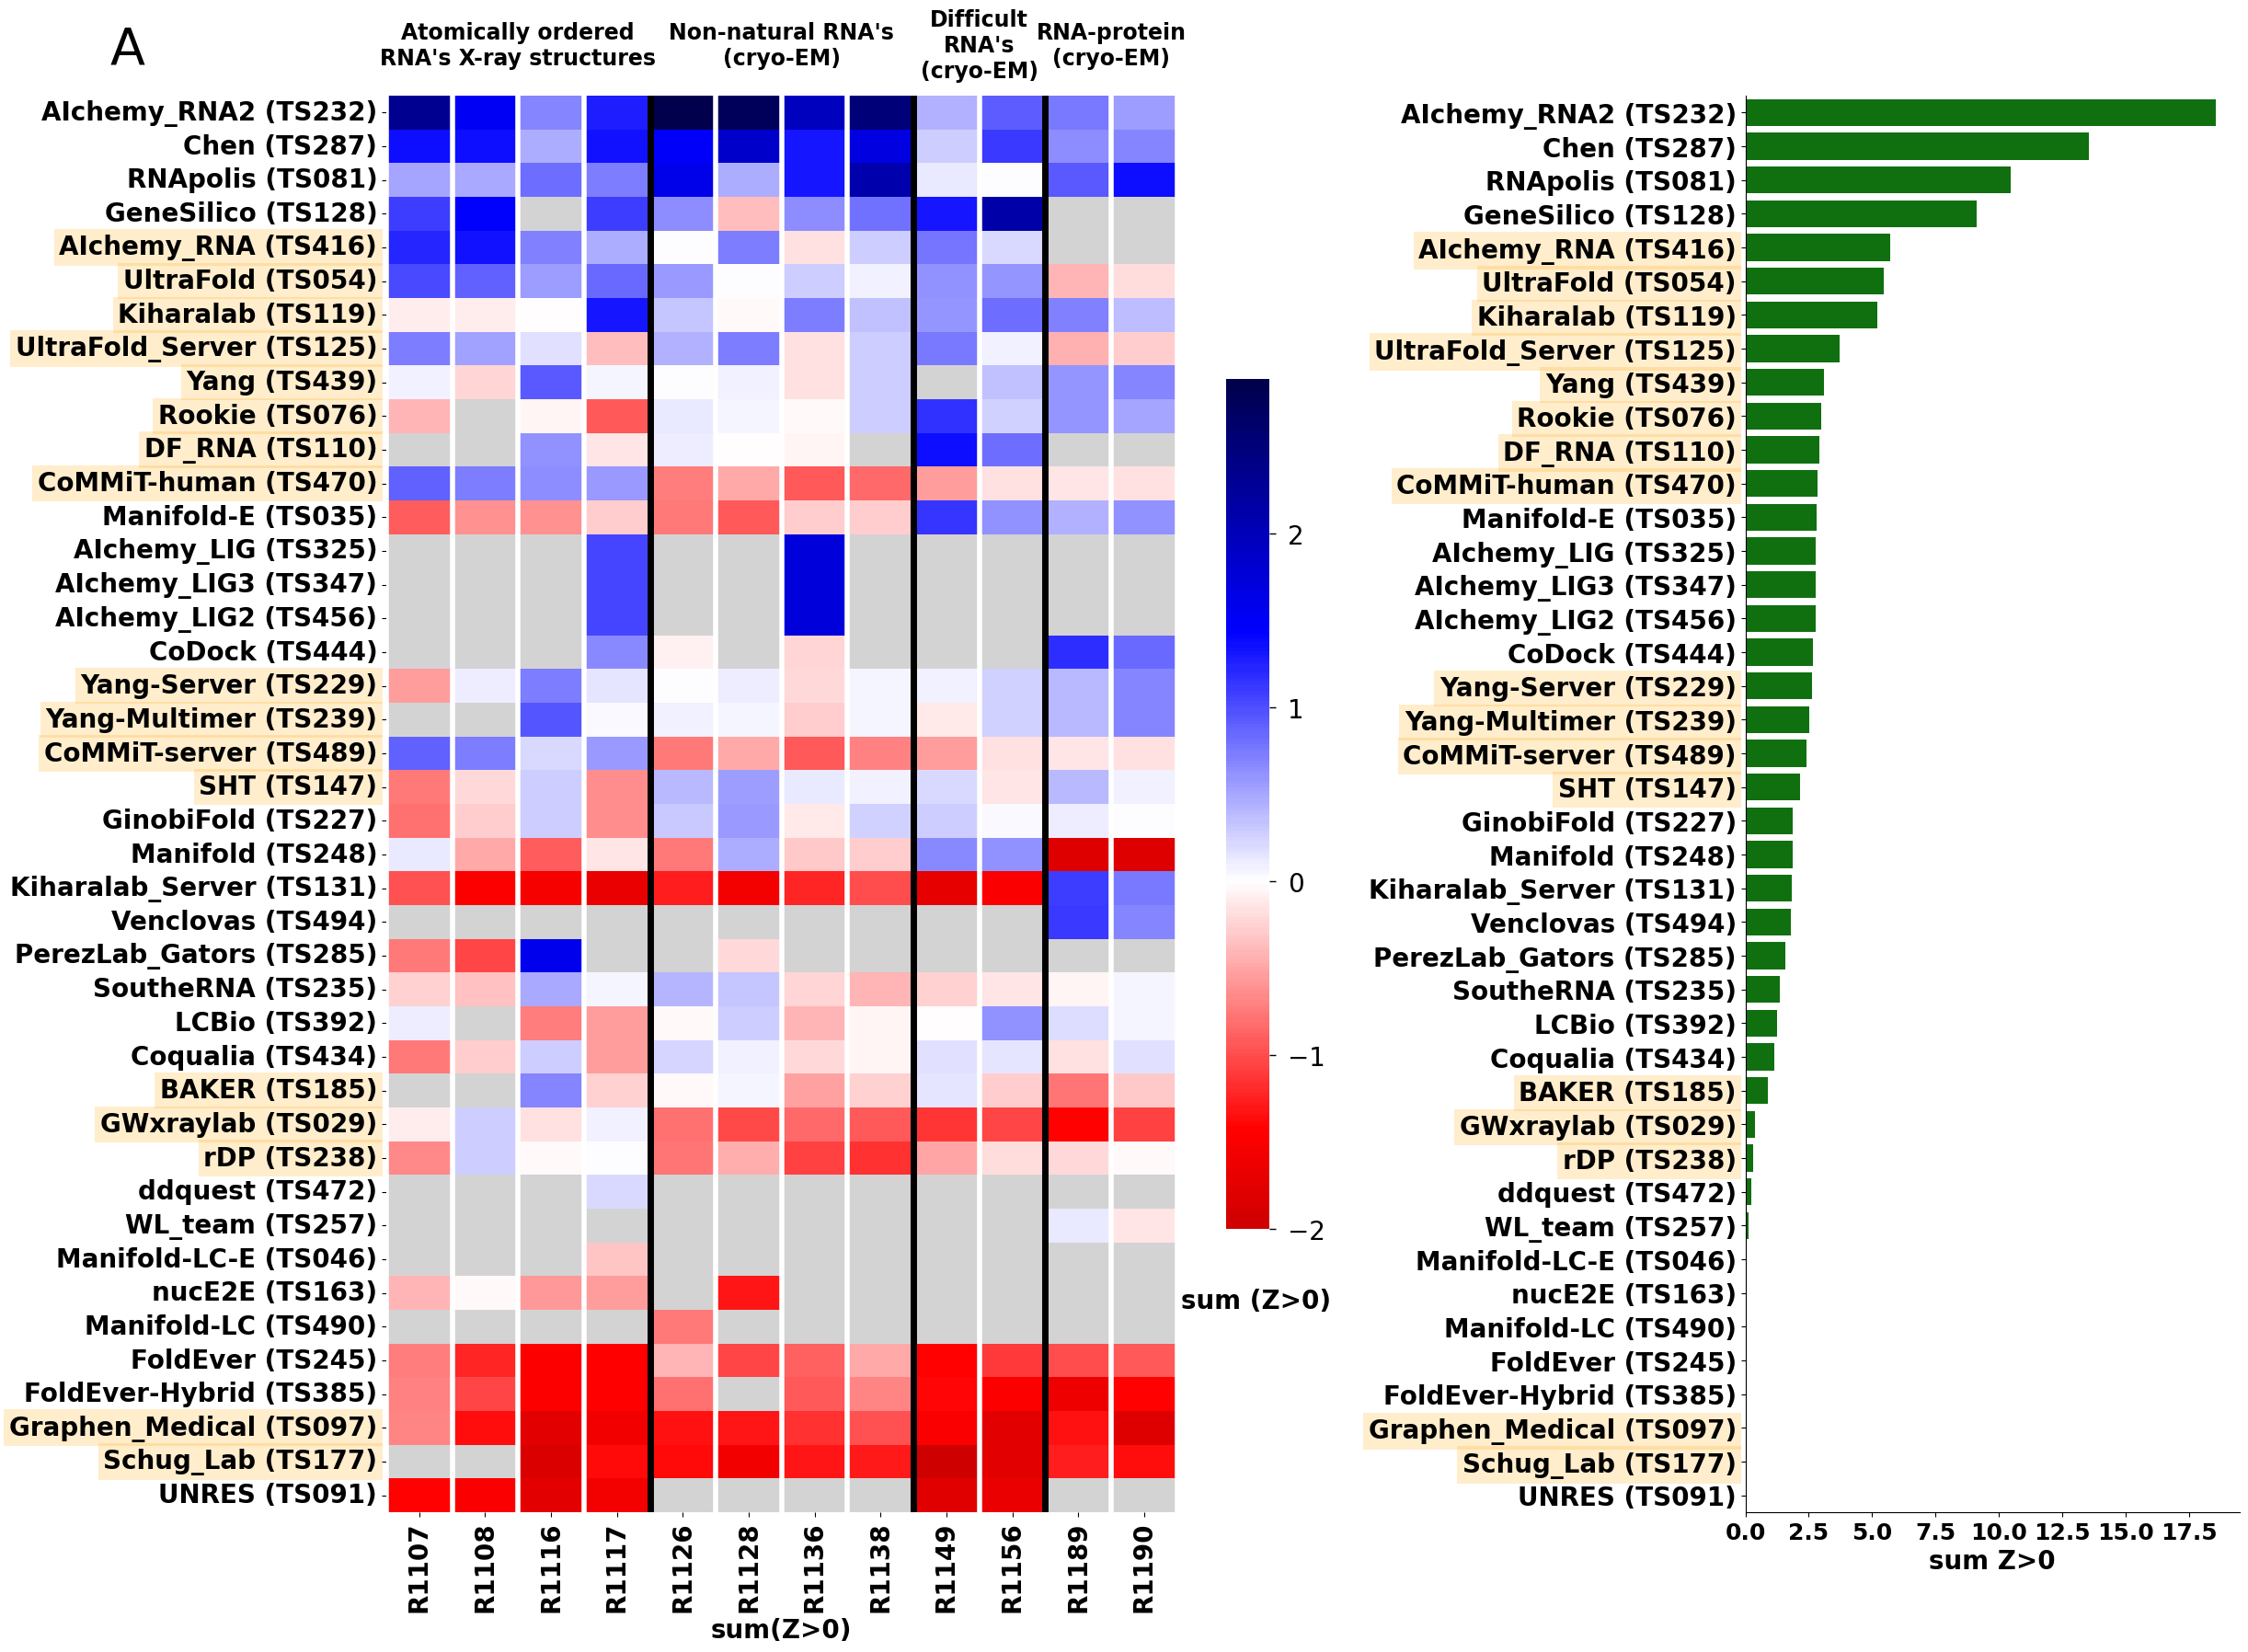

In [7]:
# Loop through each unique target in best_score, then loop through each metric in metrics and calculate z-score
for target in best_score.target.unique():
    for metric in metrics_is_lower_better:
        lower_is_better = (metrics_is_lower_better[metric] == "min")
        best_score.loc[best_score.target == target, "z_" + metric] = calc_double_z_scores(best_score[best_score.target == target][metric].to_numpy(), lower_is_better=lower_is_better, thresh=-2)

best_score["z_rna"] = calc_zrna(best_score, zrna_weights)

group_names_df = pd.read_csv("scores/group_names.csv")
group_names_df = group_names_df[["groups", "group_name"]]
group_names_df = group_names_df.rename(columns={"groups": "gr_code"})
group_names_df = best_score.merge(group_names_df, on="gr_code", how="left")
group_names = dict(zip(group_names_df.gr_code, group_names_df.group_name))

score = "z_rna"
group_score = get_group_score(best_score,score=score)
group_score["tie"] = get_group_score(best_score,agg="mean",score=score)[score]
rank_order = group_score.sort_values([score,'tie'], ascending=False).gr_code.values

fig, axes = plt.subplots(1, 2, figsize=(26, 20), gridspec_kw={'width_ratios': [2, 1]})
fig.subplots_adjust(wspace=0.5)

yticklabels = []
for gr_code in rank_order:
    s = f"{gr_code:03d}"
    yticklabels.append(group_names[gr_code] + f" (TS{s})")

########## Heatmap
best_score['gr_code'] = pd.Categorical(best_score['gr_code'],ordered=True,categories=rank_order)
pivot_all = best_score.pivot_table(index="gr_code",columns="target",values=score, dropna=False)
mask = np.isnan(pivot_all)

g = sns.heatmap(pivot_all, cmap="seismic_r", ax=axes[0], center=0, cbar_kws={'shrink': 0.6}, mask=mask, annot_kws={"size":8}) # annot=True, 
g.set_yticklabels(labels=g.get_yticklabels(),rotation = 0, size=20)
g.set_xticklabels(labels=g.get_xticklabels(),rotation = 90, size=20)
g.set_ylabel("")
g.set_facecolor('lightgrey')
g.set_yticklabels(yticklabels, fontweight='bold')
g.set_xlabel("sum(Z>0)", fontweight='bold', fontsize=20)

for label in g.get_xticklabels():
    label.set_fontweight('bold')

# Add white vertical lines between targets for beter visiblity
for i in range(pivot_all.shape[1]+1):
    g.axvline(i, color='white', lw=4)


gaps_to_draw = [4, 8, 10]

for gap in gaps_to_draw:
    g.axvline(gap, color='black', lw=5)

# Annotate text above each category
category_centers = {2 : "Atomically ordered\nRNA's X-ray structures",
                    6 : "Non-natural RNA's\n(cryo-EM)",
                    9 : "Difficult\nRNA's\n(cryo-EM)",
                    11 : "RNA-protein\n(cryo-EM)"
                    }

for center in category_centers:
    g.text(center, -1.5, category_centers[center], ha="center", va="center", color="black", size=17, fontweight='bold')

# Create colorbar
cbar = g.collections[0].colorbar
cbar.ax.tick_params(labelsize=20)
cbar.set_label("sum (Z>0)",size=20,ha='right',y=-0.1, rotation=0, va='bottom')
# Decrease the padding of the colorbar
cbar.ax.yaxis.set_tick_params(pad=0.2)
# Bold cbar label
cbar.ax.yaxis.label.set_fontweight('bold')
# Offset the colorbar ticks by a few pixels
cbar.ax.tick_params(direction='out', length=5, width=1, colors='k', pad=10)

# Label as Figure "A"
axes[0].text(-0.35, 1.05, "A", transform=axes[0].transAxes,fontsize=40, va='top', ha='left')

########## Barplot
pivot_all["Sum (Z>0)"] = pivot_all.where(pivot_all > 0).sum(1)
splot = sns.barplot(data=pivot_all, y=pivot_all.index, x="Sum (Z>0)", color='green', ax=axes[1])

# Bold and set font size to 20 for xticklabels and yticklabels and x-axis label
for label in splot.get_yticklabels():
    label.set_fontweight('bold')
    label.set_fontsize(20)
for label in splot.get_xticklabels():
    label.set_fontweight('bold')
    label.set_fontsize(18)
splot.set_xlabel("sum(Z>0)", fontweight='bold', fontsize=20)


axes[1].spines['right'].set_visible(False)
axes[1].spines['top'].set_visible(False)
axes[1].set_xlabel("sum Z>0")
axes[1].set_ylabel("")
axes[1].set_yticklabels(yticklabels, fontweight='bold')

########## Both figures
# loop through the yticklabels and highlight groups that are machine learning groups
ml_groups = [119, 416, 54, 125, 229, 110, 76, 439, 147, 239, 470, 489, 185, 238, 29, 97, 177]

for ax in [axes[0], axes[1]]:
    for label in ax.get_yticklabels():
        for gr_code in ml_groups:
            if str(gr_code) in label.get_text():
                label.set_bbox(dict(facecolor='orange', alpha=0.2, edgecolor='none'))

########## Save figure
# Save figure
plt.savefig("figures/fig3a.z_rna.png", dpi=600, bbox_inches='tight')
# Save as svg
plt.savefig("figures/fig3a.z_rna.svg", dpi=600, bbox_inches='tight')

# Table # of Models

In [84]:
# GDT > 45
# GDT > 25
# INF > 0.85
# INF > 0.7

# Group by gr_code and count the number of rows gdt > 45
gdt45 = best_score.groupby("gr_code")["gdt_ts"].apply(lambda col: col[col > 45].count()).reset_index()

# Group by gr_code and count the number of rows gdt > 25
gdt25 = best_score.groupby("gr_code")["gdt_ts"].apply(lambda col: col[col > 25].count()).reset_index()

# Group by gr_code and count the number of rows inf > 0.85
inf85 = best_score.groupby("gr_code")["inf_all"].apply(lambda col: col[col > 0.85].count()).reset_index()

# Group by gr_code and count the number of rows inf > 0.7
inf70 = best_score.groupby("gr_code")["inf_all"].apply(lambda col: col[col > 0.7].count()).reset_index()

# Merge all dataframes
summary = gdt45.merge(gdt25, on="gr_code")
summary = summary.merge(inf85, on="gr_code")
summary = summary.merge(inf70, on="gr_code")

# # Rename column to make it more readable
summary = summary.rename(columns={"gdt_ts_x": "GDT-TS > 45", "gdt_ts_y": "GDT-TS > 25", "inf_all_x": "INF_all > 0.85", "inf_all_y": "INF_all > 0.7"})
summary["gr_code"] = summary["gr_code"].astype(str)
# # rename gr_code to Groups and make it the index

# # Use group_names to get the group names
group = group_names_df[["gr_code", "group_name"]]
# Change gr_code to string
group["gr_code"] = group["gr_code"].astype(str)
# Only only unique rows
group = group.drop_duplicates().reset_index(drop=True)
# Kee 

summary = summary.merge(group, on="gr_code", how="left")


# Merge group_names to summary but only keep 41 groups

summary = summary.rename(columns={"group_name": "Groups"})

# # Set group_name to Groups + TS(gr_code)
summary["Groups"] = summary["Groups"] + " (TS" + summary["gr_code"].astype(str) + ")"

# # Drop gr_code
summary = summary.drop(columns=["gr_code"])

summary = summary.set_index("Groups")


# # export
summary.to_csv("gdt-inf_count.csv", index=True)

/var/folders/v4/f2p1h0797gdct9c1y0y4_hgh0000gn/T/ipykernel_99626/126695639.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group["gr_code"] = group["gr_code"].astype(str)


,GDT-TS > 45,GDT-TS > 25,INF_all > 0.85,INF_all > 0.7
Groups,,,,
AIchemy_RNA2 (TS232),4,10,9,10
Chen (TS287),3,8,6,12
RNApolis (TS81),2,8,5,11
GeneSilico (TS128),4,5,5,9
AIchemy_RNA (TS416),3,7,4,10
UltraFold (TS54),3,6,6,10
Kiharalab (TS119),1,6,5,12
UltraFold_Server (TS125),2,7,5,9
CoMMiT-human (TS470),3,6,2,7
